In [ ]:
# Block 1
!pip install -q diffusers transformers datasets accelerate safetokens xformers
!pip install -q torchvision Pillow

ERROR: Could not find a version that satisfies the requirement safetokens (from versions: none)
ERROR: No matching distribution found for safetokens


In [ ]:
# Block 2
import torch
from torch import nn
import math
from PIL import Image
from torchvision import transforms
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from diffusers import DDPMScheduler, AutoencoderKL, EulerAncestralDiscreteScheduler
from transformers import CLIPTokenizer, CLIPTextModel
from accelerate import Accelerator
from torch.cuda.amp import autocast

In [ ]:
# Block 3 - Fixed U-Net with Time Conditioning and Corrected Attention
from types import SimpleNamespace

# Sinusoidal embedding function (fixed to handle scalar inputs and dtype consistency)
def sinusoidal_embedding(timesteps, dim=256, dtype=torch.float32):
    # Ensure timesteps has at least one dimension and is long type
    if timesteps.dim() == 0:
        timesteps = timesteps.unsqueeze(0)

    # Convert to long to avoid truncation issues
    timesteps = timesteps.long()

    device = timesteps.device
    half_dim = dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device, dtype=dtype) * -emb)
    emb = timesteps.to(dtype)[:, None] * emb[None, :]
    emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
    return emb

# Timestep embedding module (with dtype consistency)
class TimestepEmbed(nn.Module):
    def __init__(self, dim, hidden=512):
        super().__init__()
        self.proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
        )

    def forward(self, t_emb):
        return self.proj(t_emb)

# Fixed Self-Attention (with dtype consistency)
class SelfAttention(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.norm = nn.GroupNorm(32, c)
        self.q = nn.Conv2d(c, c, 1)
        self.k = nn.Conv2d(c, c, 1)
        self.v = nn.Conv2d(c, c, 1)
        self.proj = nn.Conv2d(c, c, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        xn = self.norm(x)
        q = self.q(xn).reshape(b, c, h*w).transpose(1, 2)      # [b, hw, c]
        k = self.k(xn).reshape(b, c, h*w)                      # [b, c, hw]
        v = self.v(xn).reshape(b, c, h*w).transpose(1, 2)      # [b, hw, c]
        attn = torch.softmax(q @ k / (c ** 0.5), dim=-1)       # [b, hw, hw]
        out = attn @ v                                         # [b, hw, c]
        out = out.transpose(1, 2).reshape(b, c, h, w)
        return x + self.proj(out)

# Fixed Cross-Attention (with dtype consistency)
class CrossAttention(nn.Module):
    def __init__(self, c, embed_dim=768):
        super().__init__()
        self.norm = nn.GroupNorm(32, c)
        self.q = nn.Linear(c, c)
        self.k = nn.Linear(embed_dim, c)
        self.v = nn.Linear(embed_dim, c)
        self.proj = nn.Linear(c, c)

    def forward(self, x, emb):           # x: [b,c,h,w], emb: [b,77,768]
        b, c, h, w = x.shape
        xh = self.norm(x).view(b, c, h*w).permute(0, 2, 1)     # [b, hw, c]
        q = self.q(xh)                                         # [b, hw, c]
        k = self.k(emb)                                        # [b, seq, c]
        v = self.v(emb)                                        # [b, seq, c]
        attn = torch.softmax(q @ k.transpose(1, 2) / (c**0.5), dim=-1)
        out = attn @ v                                         # [b, hw, c]
        out = self.proj(out).permute(0, 2, 1).view(b, c, h, w)
        return x + out

# Fixed Time-conditioned ResBlock (with proper ordering)
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, t_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.norm1 = nn.GroupNorm(32, out_c)
        self.t_proj = nn.Linear(t_dim, out_c)
        self.act1 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.norm2 = nn.GroupNorm(32, out_c)
        self.act2 = nn.SiLU()
        self.residual_conv = nn.Conv2d(in_c, out_c, 1) if in_c != out_c else nn.Identity()

    def forward(self, x, t_emb):
        residual = self.residual_conv(x)

        # Proper ordering: conv -> norm -> time conditioning -> activation
        h = self.conv1(x)
        h = self.norm1(h)

        # Ensure t_emb has the right dtype and add time conditioning
        t_emb = t_emb.to(h.dtype)
        h = h + self.t_proj(t_emb)[:, :, None, None]

        h = self.act1(h)
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act2(h)

        return h + residual

# Updated MiniDiffusionUNet with time conditioning and dtype consistency
class MiniDiffusionUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embed = TimestepEmbed(256, 512)

        # Encoder
        self.conv_in = nn.Conv2d(4, 128, 3, padding=1)
        self.down1 = self.make_down_block(128, 256)
        self.down2 = self.make_down_block(256, 512)
        self.down3 = self.make_down_block(512, 1024)

        # Middle
        self.mid_conv1 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.mid_attn = CrossAttention(1024)
        self.mid_conv2 = nn.Conv2d(1024, 1024, 3, padding=1)

        # Decoder with correct skip connections
        self.up1 = self.make_up_block(1024 + 1024, 512)  # x4 (1024) + mid output (1024)
        self.up2 = self.make_up_block(512 + 512, 256)    # x3 (512) + up1 output (512)
        self.up3 = self.make_up_block(256 + 256, 128)    # x2 (256) + up2 output (256)
        self.conv_out = nn.Conv2d(128, 4, 3, padding=1)

        # Configuration for pipeline compatibility
        self.config = SimpleNamespace(
            cross_attention_dim=768,
            attention_head_dim=8,
            class_embed_type=None,
            only_cross_attention=False,
            sample_size=32,
            in_channels=4,
            out_channels=4,
            layers_per_block=2,
            block_out_channels=(128, 256, 512, 1024),
            down_block_types=[
                "DownBlock2D",
                "DownBlock2D",
                "DownBlock2D",
                "DownBlock2D"
            ],
            up_block_types=[
                "UpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
                "UpBlock2D"
            ],
            norm_num_groups=32,
            time_cond_proj_dim=None
        )

    def make_down_block(self, in_c, out_c):
        return nn.Sequential(
            ResBlock(in_c, out_c, 512),
            SelfAttention(out_c),
            nn.Conv2d(out_c, out_c, 3, stride=2, padding=1),
        )

    def make_up_block(self, in_c, out_c):
        return nn.Sequential(
            ResBlock(in_c, out_c, 512),
            SelfAttention(out_c),
            nn.ConvTranspose2d(out_c, out_c, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, sample, timestep, encoder_hidden_states):
        # Ensure encoder_hidden_states has the right dtype
        encoder_hidden_states = encoder_hidden_states.to(sample.dtype)

        # Time embedding
        t_emb = sinusoidal_embedding(timestep, 256, dtype=sample.dtype)
        t_emb = self.time_embed(t_emb)

        x = sample
        x1 = self.conv_in(x)
        x2 = self.down1[0](x1, t_emb)  # ResBlock with time conditioning
        x2 = self.down1[1](x2)         # Self-attention
        x2 = self.down1[2](x2)         # Downsample

        x3 = self.down2[0](x2, t_emb)
        x3 = self.down2[1](x3)
        x3 = self.down2[2](x3)

        x4 = self.down3[0](x3, t_emb)
        x4 = self.down3[1](x4)
        x4 = self.down3[2](x4)

        # Middle with cross-attention
        x_mid = self.mid_conv1(x4)
        x_mid = self.mid_attn(x_mid, encoder_hidden_states)
        x_mid = self.mid_conv2(x_mid)

        # Decoder with correct skip connections
        x = torch.cat([x_mid, x4], dim=1)  # x4 (1024) + mid output (1024)
        x = self.up1[0](x, t_emb)
        x = self.up1[1](x)
        x = self.up1[2](x)

        x = torch.cat([x, x3], dim=1)      # x3 (512) + up1 output (512)
        x = self.up2[0](x, t_emb)
        x = self.up2[1](x)
        x = self.up2[2](x)

        x = torch.cat([x, x2], dim=1)      # x2 (256) + up2 output (256)
        x = self.up3[0](x, t_emb)
        x = self.up3[1](x)
        x = self.up3[2](x)

        return self.conv_out(x)

In [ ]:
# Block 4 - Model Initialization (fixed)
model_id = "CompVis/stable-diffusion-v1-4"

# Load components with proper dtype handling
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=torch.float16)
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.float16)
noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Initialize U-Net in FP32
unet = MiniDiffusionUNet()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [ ]:
# Block 5 - Dataset & DataLoader (fixed normalization and added robustness)
class SDDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, image_size=256):
        self.dataset = load_dataset('csv', data_files=csv_path)['train']
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Fixed for 3 channels
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        try:
            item = self.dataset[idx]
            image_path = item['image']

            # Handle relative paths
            if not os.path.isabs(image_path):
                # Assuming images are in the same directory as the CSV
                csv_dir = os.path.dirname("/content/cleaned_descriptions.csv")
                image_path = os.path.join(csv_dir, image_path)

            image = Image.open(image_path).convert("RGB")
            return self.transform(image), item['description']
        except Exception as e:
            print(f"Skipping item {idx}: {e}")
            return None

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.tensor([]), []
    images, texts = zip(*batch)
    return torch.stack(images), list(texts)

# Optional pre-cleaning step
import os
with open("/content/descriptions.csv", "rb") as f:
    content = f.read().decode("utf-8", "replace")
with open("/content/cleaned_descriptions.csv", "w", encoding="utf-8") as f:
    f.write(content)

In [ ]:
# Block 6 - Training Setup (fixed)
accelerator = Accelerator(
    mixed_precision="fp16",
    gradient_accumulation_steps=4,
    device_placement=True
)

# Move models to accelerator device
vae = vae.to(accelerator.device)
text_encoder = text_encoder.to(accelerator.device)

# Prepare components
dataset = SDDataset("/content/cleaned_descriptions.csv")
train_dataloader = DataLoader(dataset, batch_size=8, collate_fn=collate_fn)
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4, weight_decay=1e-2)  # Added weight decay

# Let Accelerator handle mixed precision
unet, optimizer, train_dataloader = accelerator.prepare(unet, optimizer, train_dataloader)

torch.cuda.empty_cache()


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Block 7 - Training Loop (Fixed with consistent scaling and proper timestep handling)
scaling_factor = 0.18215  # Consistent scaling factor
num_epochs = 125

for epoch in range(num_epochs):
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, texts in progress_bar:
        # Skip empty batches
        if images.nelement() == 0:
            continue

        with accelerator.accumulate(unet):
            valid_texts = [t if isinstance(t, str) else "" for t in texts]

            # Tokenize with strict length control
            text_input = tokenizer(
                valid_texts,
                padding="max_length",
                max_length=77,
                truncation=True,
                return_tensors="pt"
            ).input_ids.to(accelerator.device)

            # Encode text and ensure proper dtype
            with torch.no_grad():
                text_embeddings = text_encoder(text_input)[0]
                # Cast to same dtype as latents will be
                text_embeddings = text_embeddings.to(accelerator.device, dtype=torch.float16)

            # Forward pass with text conditioning
            images = images.to(accelerator.device).half()
            with torch.no_grad():
                latents = vae.encode(images).latent_dist.sample()
                latents = latents * scaling_factor

            # Add noise - ensure timesteps are long type
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, 1000, (latents.shape[0],), device=accelerator.device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Forward pass
            with accelerator.autocast():
                noise_pred = unet(
                    sample=noisy_latents,
                    timestep=timesteps,
                    encoder_hidden_states=text_embeddings
                )
                loss = torch.nn.functional.mse_loss(noise_pred.float(), noise.float())

            # Backward pass
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

        progress_bar.set_postfix({"loss": loss.item()})

print("Training complete!")

torch.cuda.empty_cache()


Epoch 1/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 51/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 52/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 53/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 54/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 55/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 56/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 57/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 58/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 59/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 60/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 61/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 62/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 63/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 64/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 65/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 66/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 67/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 68/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 69/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 70/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 71/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 72/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 73/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 74/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 75/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 76/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 77/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 78/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 79/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 80/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 81/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 82/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 83/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 84/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 85/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 86/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 87/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 88/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 89/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 90/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 91/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 92/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 93/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 94/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 95/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 96/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 97/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 98/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 99/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 100/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 101/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 102/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 103/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 104/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 105/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 106/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 107/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 108/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 109/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 110/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 111/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 112/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 113/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 114/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 115/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 116/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 117/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 118/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 119/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 120/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 121/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 122/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 123/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 124/125:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 125/125:   0%|          | 0/13 [00:00<?, ?it/s]

Training complete!


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Block 8 - Saving
from pathlib import Path
save_dir = Path("final_model")
save_dir.mkdir(exist_ok=True)
torch.save(unet.state_dict(), save_dir/"unet.pth")
text_encoder.save_pretrained(save_dir/"text_encoder")
tokenizer.save_pretrained(save_dir/"tokenizer")

# Save config file
with open(save_dir/"config.txt", "w") as f:
    f.write(f"Fine-tuned model configuration\n")
    f.write(f"Training epochs: {num_epochs}\n")
    f.write(f"Base model: {model_id}\n")
    f.write(f"Scaling factor: {scaling_factor}\n")

print(f"All model components saved to {save_dir}")


All model components saved to final_model


Textarea(value='', description='Prompt:', layout=Layout(height='100px', width='100%'), placeholder='Enter your…

Button(button_style='success', description='Generate Images', style=ButtonStyle())

Output()

Testing the pipeline...
Test completed!


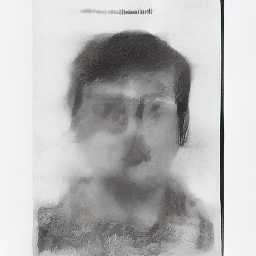

In [ ]:
# Block 9 - Fixed Inference Pipeline with proper timestep handling
class ForensicPipeline:
    def __init__(self, model_dir="final_model"):
        self.device = "cuda"
        self.scaling = 0.18215  # Consistent scaling

        # Load U-Net
        self.unet = MiniDiffusionUNet()
        self.unet.load_state_dict(torch.load(f"{model_dir}/unet.pth", map_location="cpu"))
        self.unet = self.unet.half().to(self.device)
        self.unet.eval()

        # Load other components
        self.vae = AutoencoderKL.from_pretrained(
            model_id,
            subfolder="vae",
            torch_dtype=torch.float16
        ).to(self.device)

        self.tokenizer = CLIPTokenizer.from_pretrained(f"{model_dir}/tokenizer")

        self.text_encoder = CLIPTextModel.from_pretrained(
            f"{model_dir}/text_encoder",
            torch_dtype=torch.float16
        ).to(self.device)

        # Use Euler Ancestral for better quality
        self.scheduler = EulerAncestralDiscreteScheduler.from_pretrained(
            model_id,
            subfolder="scheduler"
        )

    @property
    def dtype(self):
        return next(self.unet.parameters()).dtype

    def generate_multiple(self, prompt, num_images=3, steps=100):
        """Generate multiple images from one prompt"""
        images = []
        for i in range(num_images):
            print(f"Generating image {i+1}/{num_images}...")
            image = self.generate(prompt, steps)
            images.append(image)
        return images

    def generate(self, prompt, steps=150):
        """Main generation method"""
        # Tokenization
        text_input = self.tokenizer(
            [prompt],
            padding="max_length",
            max_length=77,
            truncation=True,
            return_tensors="pt"
        ).input_ids.to(self.device)

        # Text encoding
        with torch.no_grad():
            text_emb = self.text_encoder(text_input)[0]

        # Latent preparation
        latents = torch.randn(
            (1, 4, 32, 32),
            device=self.device,
            dtype=self.dtype
        )

        # Denoising loop
        self.scheduler.set_timesteps(steps, device=self.device)
        for t in self.scheduler.timesteps:
            # Ensure timestep is properly shaped and is long type for scheduler
            t_long = t.long().unsqueeze(0) if t.dim() == 0 else t.long()

            # Scale the model input (important for EulerAncestralDiscreteScheduler)
            latent_model_input = self.scheduler.scale_model_input(latents, t_long)

            with torch.no_grad():
                noise_pred = self.unet(
                    latent_model_input,  # Use scaled input
                    t_long,             # Use long type for timestep
                    encoder_hidden_states=text_emb
                )
                latents = self.scheduler.step(noise_pred, t_long, latents).prev_sample

        # Decoding and formatting
        with torch.no_grad():
            image = self.vae.decode(latents / self.scaling).sample[0]
            image = (image / 2 + 0.5).clamp(0, 1).cpu().permute(1, 2, 0).numpy()

        return Image.fromarray((image * 255).astype('uint8'))

# Simple GUI without complex progress indicators
import ipywidgets as widgets
from IPython.display import display, clear_output

pipe = ForensicPipeline(model_dir="final_model")

# Create a text box for the prompt
prompt_text = widgets.Textarea(
    description='Prompt:',
    placeholder='Enter your prompt here...',
    layout=widgets.Layout(width='100%', height='100px')
)

# Create a button to generate images
generate_button = widgets.Button(
    description='Generate Images',
    button_style='success'
)

# Create an output area to display images
output_area = widgets.Output()

# Function to handle button click
def on_generate_button_click(b):
    with output_area:
        clear_output()
        prompt = prompt_text.value
        if not prompt:
            print("Please enter a prompt.")
            return

        print("Generating images... This may take a few minutes.")

        # Generate images
        generated_images = []
        for i in range(3):
            print(f"Generating image {i+1}/3...")
            img = pipe.generate(prompt, steps=50)  # Reduced steps for testing
            generated_images.append(img)

        # Display images
        clear_output()
        for img in generated_images:
            display(img)

# Link the button click event to the function
generate_button.on_click(on_generate_button_click)

# Display the GUI
display(prompt_text, generate_button, output_area)

# Test the pipeline directly
print("Testing the pipeline...")
test_image = pipe.generate("a simple test", steps=20)
print("Test completed!")
display(test_image)